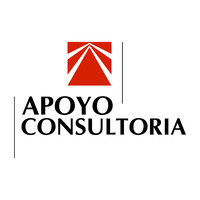
# Interpolación

Esta librería realiza la interpolación del PBI a frecuencia mensual, explicada en el punto punto 2.2 (Filtro de Kalman), la cual fue estimada en el modulo Kalman.

Se estima un filtro de Kalman para interpolar el PBI a frecuencia mensual. El PBI trimestral es observado cada tres meses, y las contribuciones de cada mes sumadas generan esta variable.

##### Ecuacion normal:

$$\Delta y_t^T = \Delta y_t^m  + \Delta y_{t-1}^m + \Delta y_{t-2}^m$$
##### Ecuaciones de transicion:
$$\Delta y_{t-1}^m = \phi \Delta y_{t-1}^m + \beta X_t + \epsilon_t$$
$$\epsilon_t = \rho \epsilon_t + \eta_t$$

$X_t$ son las variables usadas para interpolar.



### Librerías y rutas

In [1]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns
from ipynb.fs.defs.ConstruccionBasedeDatos import BasedeDatos
from ipynb.fs.defs.m1Kalman import interpol
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
#Frecuencias de variables
frq1 = 3
frq2 = 1

In [3]:
rutaOrigen = 'inputs/'
rutaEstimacion = 'model_interpol/'
rutaDestino = 'resultados/'

### Importación base agregada

In [4]:
_,_,_,bd_all = BasedeDatos(rutaOrigen + 'bd_Panama.xlsx')

C:\Users\eo\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\eo\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
VariablesPBI = ['pbif_Trimestre_VariacionAnual',
               ]
VariablesExogenas = list(set([x for x in bd_all.columns if 'Mensual_VariacionAnual' in x]) - set(VariablesPBI))

### Función de interpolacion

In [6]:
def kalman_resultados(model_input,bd_all,var,frq1,frq2,test_size):
    
    #Importando modelo
    
    bd_model = pd.read_excel(model_input,sheet_name = var[0:20], index_col = 0 )

    
    y = [var]
    X = bd_model.index[3:].tolist()
    
    NombreVariableFrecuencia1Filtrada = y[0][0:6] + '_VariacionFrecuencia1_Filtrada'
    NombreVariableFrecuencia2Filtrada = y[0][0:6] + '_VariacionFrecuencia2_Filtrada'

    NombreVariableFrecuencia1Imputada = y[0][0:6] + '_VariacionFrecuencia1_Imputada'
    NombreVariableFrecuencia2Imputada = y[0][0:6] + '_VariacionFrecuencia2_Imputada'
    
    ParametrosOptimizados = bd_model.Valor.values.tolist()
    
    _, KalmanInterpolador, BaseInterpolacion = interpol(bd_all,X,y,frq1,frq2,ParametrosOptimizados,test_size)
    
    BaseInterpolacion[NombreVariableFrecuencia1Filtrada] = pd.DataFrame(KalmanInterpolador.filter(BaseInterpolacion[y])[0]).set_index(BaseInterpolacion.index)[0] * frq1/frq2
    BaseInterpolacion[NombreVariableFrecuencia2Filtrada] = BaseInterpolacion[NombreVariableFrecuencia1Filtrada].rolling(int(frq1/frq2)).mean()
    BaseInterpolacion[NombreVariableFrecuencia1Imputada] = pd.DataFrame(KalmanInterpolador.smooth(BaseInterpolacion[y])[0]).set_index(BaseInterpolacion.index)[0] * frq1/frq2
    BaseInterpolacion[NombreVariableFrecuencia2Imputada] = BaseInterpolacion[NombreVariableFrecuencia1Imputada].rolling(int(frq1/frq2)).mean()
    
    baseResultados = BaseInterpolacion[[NombreVariableFrecuencia1Filtrada,NombreVariableFrecuencia2Filtrada,NombreVariableFrecuencia1Imputada,NombreVariableFrecuencia2Imputada]]
    
    return BaseInterpolacion, KalmanInterpolador, baseResultados

### Interpolación y proyección mensual

In [14]:
baseFinal = pd.DataFrame()
for y in VariablesPBI:

    _,_,baseInterpolacion = kalman_resultados(rutaEstimacion + 'ModelosKalman.xlsx', bd_all, y, frq1, frq2,0)
    baseFinal = baseFinal.join(baseInterpolacion[baseInterpolacion.columns[2:]], how = 'outer')

In [15]:
with pd.ExcelWriter(rutaDestino + 'baseInterpolacion.xlsx') as writer:
    baseFinal.to_excel(writer, sheet_name = 'Interpol')

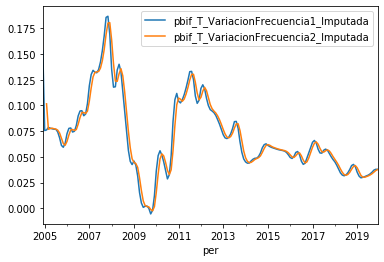

In [16]:
baseFinal.plot()